In [ ]:
# default_exp find_duplicates

# Find Duplicates

> Finds duplicate images and records them.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastcore.all import *
import pandas as pd
import numpy as np
from PIL import Image
from hashlib import md5
from itertools import chain
from typing import List

## End Result

At the end, we are interested in having a table that tells us 2 main pieces of information:
   1. What images are duplicated across the train and test sets? What are the id's and categories of those images?
       - We can label these products in the test set by hand, since we'll be able to see what category they are in the train set
   2. What images appear in multiple different categories?
       - These images will be confusing to the network if processing on an image-level, so we might do something with these

Ultimately, a table with the following information would be good:

|image hash|image name|\_id|category_id|in_test|
|---|---|---|---|---|
|as12dfjwka3k3qjkdjnw|100_1.jpg|100|1000021794|False|
|as12dfjwka3k3qjkdjnw|2_0.jpg|2|-1|True|

## Implementation

In [ ]:
path = Path("data"); path.ls()

(#13) [Path('data/multiple_categories.csv'),Path('data/sample_submission.csv'),Path('data/train.bson'),Path('data/train_example.bson'),Path('data/cdiscount-image-classification-challenge.zip'),Path('data/multiple_categories_and_in_train_and_test.csv'),Path('data/test.bson'),Path('data/test.csv'),Path('data/train.csv'),Path('data/train_example.csv')...]

In [ ]:
train_csv = pd.read_csv(path/"train_example.csv"); train_csv.head()

,_id,category_id
0,0,1000010653
1,1,1000010653
2,2,1000004079
3,3,1000004141
4,4,1000015539


In [ ]:
len(train_csv)

82

### Process Row of DataFrame

In [ ]:
train_csv.iloc[0]

_id                     0
category_id    1000010653
Name: 0, dtype: int64

In [ ]:
#export
def get_image_path(data_path, _id, img_num): return data_path/"images"/f"{_id}_{img_num}.jpg"

In [ ]:
img_path = get_image_path(path, 0, 0); img_path

Path('data/images/0_0.jpg')

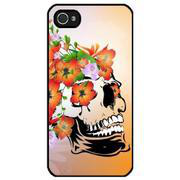

In [ ]:
img = Image.open(img_path); img

In [ ]:
#export
def load_img_as_array(path): return np.array(Image.open(path))

In [ ]:
arr = load_img_as_array(img_path); arr.shape

(180, 180, 3)

In [ ]:
#export
def get_hash(array: np.ndarray): return md5(array.tobytes()).hexdigest()

In [ ]:
get_hash(arr)

'83c921601c6bc5e3d09576ac418091ed'

In [ ]:
#export
MAX_IMAGES_PER_PRODUCT = 4  # each product has up to 4 images

In [ ]:
with ExceptionExpected(ex=FileNotFoundError): load_img_as_array("INVALID_PATH")

In [ ]:
#export
def GetProcessRowFunc(data_path: Path, is_test: bool):
    """Get func to process row of train.csv or test_csv."""
    def _inner(*row_values):
        """Processes single row and returns (image hash, image name, _id, category_id, in_test), for each image in product."""
        if is_test: _id, = row_values
        else:       _id,category_id = row_values
        processed_row = []
        for img_num in range(MAX_IMAGES_PER_PRODUCT):
            img_path = get_image_path(data_path, _id, img_num)
            try: _hash = get_hash(load_img_as_array(img_path))
            except FileNotFoundError: break  # Processed all product's images
            processed_row.append((_hash, img_path.name, _id, -1 if is_test else category_id, is_test))
        return processed_row
    return _inner

In [ ]:
train_csv_func = GetProcessRowFunc(path, is_test=False)
_id,category_id = train_csv["_id"][0],train_csv["category_id"][0]
test_eq([('83c921601c6bc5e3d09576ac418091ed', '0_0.jpg', 0, 1000010653, False)], 
        train_csv_func(_id, category_id))
test_csv_func = GetProcessRowFunc(path, is_test=True)
test_eq([('83c921601c6bc5e3d09576ac418091ed', '0_0.jpg', 0, -1, True)], 
        test_csv_func(_id))

### Apply Processing Function to Entire DataFrame to Get Intermediate DataFrame

In [ ]:
#export
def process_df_helper(df, data_path: Path):
    """Processes a train/test dataframe and returns the intermediate dataframe with hashes."""
    process_row_func = GetProcessRowFunc(data_path, is_test="category_id" not in df)
    processed_products = [process_row_func(*row) for row in zip(*[df[col] for col in df.columns])]
    processed_df = pd.DataFrame(chain.from_iterable(processed_products),
                                columns=["image_hash", "image_name", "_id", "category_id", "in_test"])
    return processed_df.set_index("image_hash")

In [ ]:
intermediate_df = process_df_helper(train_csv, path); intermediate_df.head()

,image_name,_id,category_id,in_test
image_hash,,,,
83c921601c6bc5e3d09576ac418091ed,0_0.jpg,0,1000010653,False
fb7e2ef84ef894f54d609c04785d0778,1_0.jpg,1,1000010653,False
9683ff26cb34890105f00303b1b03deb,2_0.jpg,2,1000004079,False
7d034b74233590a20f39dcb6cbba3af6,3_0.jpg,3,1000004141,False
b40b44e5acdabeb099eaae39b2654d41,4_0.jpg,4,1000015539,False


In [ ]:
train_csv.head()

,_id,category_id
0,0,1000010653
1,1,1000010653
2,2,1000004079
3,3,1000004141
4,4,1000015539


In [ ]:
#export
def process_df(df, data_path: Path, n_workers=None):
    """Applies `process_df_helper` in parallel across df."""
    proc_func = partial(process_df_helper, data_path=data_path)
    chunks = np.array_split(df, int(len(df/100)))
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        res = ex.map(proc_func, chunks)
    return pd.concat(list(res))

In [ ]:
%time process_df(train_csv, path, n_workers=1); pass

CPU times: user 95.9 ms, sys: 10.6 ms, total: 107 ms
Wall time: 310 ms


In [ ]:
%time process_df(train_csv, path, n_workers=None); pass

CPU times: user 79.8 ms, sys: 65.8 ms, total: 146 ms
Wall time: 199 ms


### Use Intermediate DataFrame to Accomplish Objectives

In [ ]:
#export
def contains_multiple_values_in_column(df, col): return len(df[col].unique()) > 1
def appears_in_multiple_categories(df): return contains_multiple_values_in_column(df, "category_id")
def appears_in_train_and_test(df): return contains_multiple_values_in_column(df, "in_test")

In [ ]:
duplicated_images_df = intermediate_df.groupby("image_hash")
assert duplicated_images_df.filter(appears_in_multiple_categories).empty
assert duplicated_images_df.filter(appears_in_train_and_test).empty

## Script

In [ ]:
intermediate_df.to_csv()

'image_hash,image_name,_id,category_id,in_test\n83c921601c6bc5e3d09576ac418091ed,0_0.jpg,0,1000010653,False\nfb7e2ef84ef894f54d609c04785d0778,1_0.jpg,1,1000010653,False\n9683ff26cb34890105f00303b1b03deb,2_0.jpg,2,1000004079,False\n7d034b74233590a20f39dcb6cbba3af6,3_0.jpg,3,1000004141,False\nb40b44e5acdabeb099eaae39b2654d41,4_0.jpg,4,1000015539,False\nb482849c3eb798f38d6e8b7c75cfaa71,5_0.jpg,5,1000010653,False\nedd8359dea0181dcecdccac89cd9e4c3,6_0.jpg,6,1000005744,False\naf0f92a50f618d0044cb1fb64e014f3e,7_0.jpg,7,1000004079,False\n10931d19c8e5a2694541fb9630666bbe,8_0.jpg,8,1000010667,False\nf3d45a8f137c469c3d2c362e2b1cbc2f,9_0.jpg,9,1000018290,False\n4d35611135a7625b93f5104dc3177652,11_0.jpg,11,1000010653,False\n02f9a479e0a0af3b51e1a063e4c70809,12_0.jpg,12,1000018306,False\ncd4698e666a61e5049707f6087758eda,13_0.jpg,13,1000010961,False\n5121c661ae29c606e4f9ff9b6866eef9,13_1.jpg,13,1000010961,False\n9d37987dbb4326ecdf750a9c98a5abbc,13_2.jpg,13,1000010961,False\n7054b7a740ad48ba8ff71807290

In [ ]:
path

Path('data')

In [ ]:
t = L(path/"train.csv")

In [ ]:
t

(#1) [Path('data/train.csv')]

In [ ]:
t.with_name(f"{t.stem}_hashes.csv")

Path('data/train_hashes.csv')

In [ ]:
#export
@call_parse
def find_duplicates(
    path: Param("Path to data dir", type=Path),
    n_workers: Param("Number of workers, defaults to all cores", type=int)=None,
) -> List[pd.DataFrame]:
    """Checks for duplicates."""
    # Process CSVs
    csv_paths = L(path/"train.csv", path/"test.csv")
    dfs = []
    for csv_path in csv_paths:
        save_path = csv_path.with_name(f"{csv_path.stem}_hashes.csv")
        if save_path.exists(): break  # File previously processed
        processed_df = process_df(pd.read_csv(csv_path), data_path=path, n_workers=n_workers)
        processed_df.to_csv(save_path)
        dfs.append(processed_df)
    intermediate_df = pd.concat(dfs) if len(dfs) > 1 else dfs[0]

    # Check for duplicates
    duplicated_imgs_df = intermediate_df.groupby("image_hash")
    multiple_categories_df = duplicated_imgs_df.filter(appears_in_multiple_categories)
    in_train_and_test_df = duplicated_imgs_df.filter(appears_in_train_and_test)
    both_df = multiple_categories_df.merge(in_train_and_test_df)

    # Save results
    multiple_categories_df.to_csv(path/"multiple_categories.csv")
    in_train_and_test_df.to_csv(path/"in_train_and_test.csv")
    both_df.to_csv(path/"multiple_categories_and_in_train_and_test.csv", index=False)
    return multiple_categories_df, in_train_and_test_df, both_df

In [ ]:
#slow
%time multiple_categories_df, in_train_and_test_df, both_df = find_duplicates(path)

KeyboardInterrupt: 

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_find_duplicates.ipynb.
Converted index.ipynb.
